# Train a model on the crunchy-snow dataset

In [1]:
parent_dir = '/home/jovyan/crunchy-snow'

## Setup:

In [ ]:
import os

os.chdir(parent_dir)
!pip install -e .

In [ ]:
#!mamba env create -f environment.yml 
!conda init
!conda activate crunchy-snow

## Code:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import seaborn as sns

import torch
from torch.utils.data import DataLoader
import torch.optim as optim                   # Package for implementing various optimization algorithms

import torch.nn as nn
import torch.nn.functional as F               # Functions (convolution, activation, loss, etc.)

from tqdm import tqdm
import pickle

import crunchy_snow.models
import crunchy_snow.dataset

import sklearn.metrics as skmetrics

In [3]:
available_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Available device: {available_device}")

Available device: cuda


In [4]:
# flag for whether GPUs are available

if available_device == 'cuda':
    gpus = True

## Prepare dataloader

In [5]:
# get paths to data
train_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v3/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v3/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [6]:
len(train_path_list)

12382

In [7]:
len(val_path_list)

2160

In [8]:
# to test code with a small sample of the data
import random
random.seed(10)

n_imgs = 100

train_path_list = random.sample(train_path_list, n_imgs)
val_path_list = random.sample(val_path_list, n_imgs)

In [9]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

In [10]:
# prepare training and validation dataloaders

train_batch = 16

train_data = crunchy_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=train_batch, shuffle=False)

val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=False)

In [11]:
print(selected_channels)

['aso_sd', 'aso_gap_map', 'snowon_vv', 'snowon_vh', 'snowoff_vv', 'snowoff_vh', 'snowon_vv_mean', 'snowon_vh_mean', 'snowoff_vv_mean', 'snowoff_vh_mean', 'snowon_cr', 'snowoff_cr', 'delta_cr', 'rtc_gap_map', 'rtc_mean_gap_map', 'aerosol_optical_thickness', 'coastal_aerosol', 'blue', 'green', 'red', 'red_edge1', 'red_edge2', 'red_edge3', 'nir', 'water_vapor', 'swir1', 'swir2', 'scene_class_map', 'water_vapor_product', 'ndvi', 'ndsi', 'ndwi', 's2_gap_map', 'fcf', 'elevation', 'latitude', 'longitude', 'dowy']


In [12]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr',
    'scene_class_map' # new var
]

In [13]:
omitted_channels = np.setdiff1d(selected_channels,input_channels)
print(omitted_channels)

['aerosol_optical_thickness' 'aso_gap_map' 'aso_sd' 'coastal_aerosol'
 'delta_cr' 'dowy' 'latitude' 'longitude' 'nir' 'red_edge1' 'red_edge2'
 'red_edge3' 'rtc_gap_map' 'rtc_mean_gap_map' 's2_gap_map'
 'snowoff_vh_mean' 'snowoff_vv_mean' 'snowon_vh_mean' 'snowon_vv_mean'
 'swir1' 'swir2' 'water_vapor' 'water_vapor_product']


## Train model

In [14]:
# import model
# model = crunchy_snow.models.SimpleCNN(n_input_channels=len(input_channels))
#model = crunchy_snow.models.UNet(n_input_channels=len(input_channels))           
# model = crunchy_snow.models.ResUNet(n_input_channels=len(input_channels))                # predicted fields are smooth
model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
# model = crunchy_snow.models.VisionTransformer(n_input_channels=len(input_channels))      # predicted fields are noisy

if gpus == True:
    model.to('cuda');  # Run on GPU

# name your model
model_name = 'mandachasteen_ResDepth_sceneclassmap'

In [15]:
# Define optimizer and loss function

learning_rate = 0.0003
epochs = 16

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data with tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        
        # prepare inputs by concatenating along channel dimension
        if gpus == True:
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
        else:
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        if gpus == True:
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
        else:
            pred_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))
        
        # Calculate loss
        if gpus == True:
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            epoch_loss.append(loss.item())
        else:
            loss = loss_fn(pred_sd, aso_sd)
            epoch_loss.append(loss.item())
            
        # Update tqdm progress bar with batch loss
        pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})


        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data with tqdm progress bar
    for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            
            # prepare inputs by concatenating along channel dimension
            if gpus == True:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            else:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)

            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            if gpus == True:
                pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
                aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
                print('Predictions on cuda')
            else:
                pred_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
                aso_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))
                print('Predictions on cpu')
                
            # Calculate loss
            if gpus == True:
                loss = loss_fn(pred_sd, aso_sd.to('cuda'))
                val_temp_loss.append(loss.item())
            else:
                loss = loss_fn(pred_sd, aso_sd)
                val_temp_loss.append(loss.item())
                
    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../../weights/{model_name}')

    # # save loss 
    # with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)


Starting epoch 1


Epoch 1/16: 100%|██████████████████████████████████| 7/7 [00:11<00:00,  1.68s/batch, batch loss=0.000274, mean epoch loss=0.00457]


Training loss: 0.004567154192565275


Validation:   1%|          | 1/100 [00:00<00:10,  9.56batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:16,  5.94batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:18,  5.29batch/s]

Predictions on cuda
Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:15,  5.91batch/s]

Predictions on cuda
Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:16,  5.52batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:17,  5.27batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:17,  5.14batch/s]

Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:18,  4.81batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:02<00:18,  4.81batch/s]

Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:17,  4.85batch/s]

Predictions on cuda
Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:17,  4.84batch/s]

Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:17,  4.82batch/s]

Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:03<00:17,  4.67batch/s]

Predictions on cuda
Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:03<00:17,  4.65batch/s]

Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:17,  4.70batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:17,  4.66batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:04<00:17,  4.40batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:04<00:17,  4.44batch/s]

Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:04<00:17,  4.46batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:17,  4.44batch/s]

Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:05<00:16,  4.44batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:05<00:13,  5.23batch/s]

Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:05<00:15,  4.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:06<00:13,  5.26batch/s]

Predictions on cuda


Validation:  31%|███       | 31/100 [00:06<00:13,  5.12batch/s]

Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:06<00:13,  4.95batch/s]

Predictions on cuda


Validation:  34%|███▍      | 34/100 [00:06<00:11,  5.55batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:07<00:10,  5.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  38%|███▊      | 38/100 [00:07<00:10,  6.10batch/s]

Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:07<00:10,  5.68batch/s]

Predictions on cuda


Validation:  40%|████      | 40/100 [00:07<00:11,  5.31batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:08<00:11,  5.18batch/s]

Predictions on cuda
Predictions on cuda


Validation:  44%|████▍     | 44/100 [00:08<00:10,  5.19batch/s]

Predictions on cuda


Validation:  46%|████▌     | 46/100 [00:09<00:11,  4.79batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:09<00:10,  4.94batch/s]

Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:09<00:10,  4.86batch/s]

Predictions on cuda
Predictions on cuda


Validation:  50%|█████     | 50/100 [00:09<00:10,  4.76batch/s]

Predictions on cuda


Validation:  51%|█████     | 51/100 [00:10<00:10,  4.69batch/s]

Predictions on cuda


Validation:  52%|█████▏    | 52/100 [00:10<00:10,  4.60batch/s]

Predictions on cuda


Validation:  54%|█████▍    | 54/100 [00:10<00:09,  4.86batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:11<00:09,  4.71batch/s]

Predictions on cuda


Validation:  56%|█████▌    | 56/100 [00:11<00:09,  4.72batch/s]

Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:11<00:09,  4.61batch/s]

Predictions on cuda


Validation:  58%|█████▊    | 58/100 [00:11<00:08,  4.69batch/s]

Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:11<00:08,  4.58batch/s]

Predictions on cuda


Validation:  60%|██████    | 60/100 [00:12<00:08,  4.69batch/s]

Predictions on cuda


Validation:  62%|██████▏   | 62/100 [00:12<00:07,  4.83batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:12<00:07,  4.73batch/s]

Predictions on cuda
Predictions on cuda


Validation:  66%|██████▌   | 66/100 [00:13<00:06,  5.58batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:13<00:06,  5.12batch/s]

Predictions on cuda


Validation:  68%|██████▊   | 68/100 [00:13<00:06,  5.05batch/s]

Predictions on cuda


Validation:  70%|███████   | 70/100 [00:14<00:05,  5.07batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:14<00:06,  4.71batch/s]

Predictions on cuda


Validation:  72%|███████▏  | 72/100 [00:14<00:05,  4.69batch/s]

Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:14<00:05,  4.73batch/s]

Predictions on cuda


Validation:  74%|███████▍  | 74/100 [00:15<00:05,  4.53batch/s]

Predictions on cuda
Predictions on cuda


Validation:  76%|███████▌  | 76/100 [00:15<00:04,  5.37batch/s]

Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:15<00:03,  5.71batch/s]

Predictions on cuda
Predictions on cuda


Validation:  80%|████████  | 80/100 [00:15<00:03,  5.42batch/s]

Predictions on cuda
Predictions on cuda


Validation:  82%|████████▏ | 82/100 [00:16<00:02,  6.01batch/s]

Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:16<00:02,  5.74batch/s]

Predictions on cuda


Validation:  84%|████████▍ | 84/100 [00:16<00:02,  5.51batch/s]

Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:16<00:02,  5.33batch/s]

Predictions on cuda


Validation:  87%|████████▋ | 87/100 [00:17<00:02,  5.24batch/s]

Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:17<00:02,  5.02batch/s]

Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:18<00:01,  5.22batch/s]

Predictions on cuda
Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:18<00:01,  5.09batch/s]

Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:18<00:00,  7.06batch/s]

Predictions on cuda
Predictions on cuda


Validation:  96%|█████████▌| 96/100 [00:18<00:00,  6.18batch/s]

Predictions on cuda
Predictions on cuda


Validation:  98%|█████████▊| 98/100 [00:19<00:00,  6.34batch/s]

Predictions on cuda


Validation:  99%|█████████▉| 99/100 [00:19<00:00,  5.51batch/s]

Predictions on cuda


Validation: 100%|██████████| 100/100 [00:19<00:00,  5.09batch/s]


Predictions on cuda
Validation loss: 0.0028390646375908092

Starting epoch 2


Epoch 2/16: 100%|██████████████████████████████████| 7/7 [00:08<00:00,  1.23s/batch, batch loss=0.000822, mean epoch loss=0.00186]


Training loss: 0.0018591009845424975


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:13,  7.14batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:15,  6.23batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:13,  6.95batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:14,  6.37batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:15,  6.16batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:15,  5.92batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:15,  5.89batch/s]

Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:15,  5.70batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:16,  5.53batch/s]

Predictions on cuda


Validation:  12%|█▏        | 12/100 [00:02<00:16,  5.47batch/s]

Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:15,  5.57batch/s]

Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:15,  5.45batch/s]

Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.42batch/s]

Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:02<00:15,  5.46batch/s]

Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:02<00:15,  5.49batch/s]

Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:03<00:14,  5.63batch/s]

Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:14,  5.77batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:14,  5.54batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:14,  5.56batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:03<00:13,  5.61batch/s]

Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:04<00:13,  5.54batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:13,  5.61batch/s]

Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:13,  5.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:11,  6.58batch/s]

Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:11,  6.23batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:05<00:10,  6.74batch/s]

Predictions on cuda


Validation:  31%|███       | 31/100 [00:05<00:10,  6.45batch/s]

Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:11,  6.10batch/s]

Predictions on cuda


Validation:  33%|███▎      | 33/100 [00:05<00:11,  5.91batch/s]

Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:08,  7.45batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:05<00:09,  6.81batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:09,  6.53batch/s]

Predictions on cuda
Predictions on cuda


Validation:  41%|████      | 41/100 [00:06<00:10,  5.89batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:07<00:09,  5.78batch/s]

Predictions on cuda
Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:09,  6.01batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:09,  5.69batch/s]

Predictions on cuda
Predictions on cuda


Validation:  48%|████▊     | 48/100 [00:08<00:09,  5.55batch/s]

Predictions on cuda


Validation:  50%|█████     | 50/100 [00:08<00:09,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  52%|█████▏    | 52/100 [00:08<00:08,  5.57batch/s]

Predictions on cuda
Predictions on cuda


Validation:  54%|█████▍    | 54/100 [00:09<00:07,  5.77batch/s]

Predictions on cuda
Predictions on cuda


Validation:  56%|█████▌    | 56/100 [00:09<00:07,  5.81batch/s]

Predictions on cuda
Predictions on cuda


Validation:  58%|█████▊    | 58/100 [00:09<00:07,  5.81batch/s]

Predictions on cuda
Predictions on cuda


Validation:  60%|██████    | 60/100 [00:10<00:06,  5.72batch/s]

Predictions on cuda
Predictions on cuda


Validation:  62%|██████▏   | 62/100 [00:10<00:06,  5.96batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:06,  5.79batch/s]

Predictions on cuda
Predictions on cuda


Validation:  66%|██████▌   | 66/100 [00:11<00:05,  6.58batch/s]

Predictions on cuda
Predictions on cuda


Validation:  68%|██████▊   | 68/100 [00:11<00:05,  6.08batch/s]

Predictions on cuda
Predictions on cuda


Validation:  70%|███████   | 70/100 [00:11<00:05,  5.86batch/s]

Predictions on cuda
Predictions on cuda


Validation:  72%|███████▏  | 72/100 [00:12<00:04,  5.78batch/s]

Predictions on cuda
Predictions on cuda


Validation:  74%|███████▍  | 74/100 [00:12<00:04,  5.64batch/s]

Predictions on cuda
Predictions on cuda


Validation:  76%|███████▌  | 76/100 [00:12<00:03,  6.30batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  80%|████████  | 80/100 [00:13<00:03,  6.08batch/s]

Predictions on cuda
Predictions on cuda


Validation:  82%|████████▏ | 82/100 [00:13<00:02,  6.64batch/s]

Predictions on cuda
Predictions on cuda


Validation:  84%|████████▍ | 84/100 [00:14<00:02,  6.02batch/s]

Predictions on cuda
Predictions on cuda


Validation:  86%|████████▌ | 86/100 [00:14<00:02,  5.89batch/s]

Predictions on cuda
Predictions on cuda


Validation:  88%|████████▊ | 88/100 [00:14<00:02,  5.82batch/s]

Predictions on cuda
Predictions on cuda


Validation:  90%|█████████ | 90/100 [00:15<00:01,  5.73batch/s]

Predictions on cuda
Predictions on cuda


Validation:  92%|█████████▏| 92/100 [00:15<00:01,  5.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:15<00:00,  7.45batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  96%|█████████▌| 96/100 [00:16<00:00,  6.71batch/s]

Predictions on cuda
Predictions on cuda


Validation:  99%|█████████▉| 99/100 [00:16<00:00,  6.87batch/s]

Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:16<00:00,  6.02batch/s]


Predictions on cuda
Validation loss: 0.0016857706828432128

Starting epoch 3


Epoch 3/16: 100%|██████████████████████████████████| 7/7 [00:08<00:00,  1.17s/batch, batch loss=0.000407, mean epoch loss=0.00158]


Training loss: 0.0015834022779017687


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:12,  7.61batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:14,  6.69batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:12,  7.37batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:13,  7.02batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:14,  6.46batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:14,  6.33batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:14,  6.14batch/s]

Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:15,  5.81batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:15,  5.88batch/s]

Predictions on cuda


Validation:  12%|█▏        | 12/100 [00:01<00:14,  5.97batch/s]

Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:14,  5.96batch/s]

Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:14,  5.93batch/s]

Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.66batch/s]

Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:02<00:15,  5.53batch/s]

Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:02<00:14,  5.64batch/s]

Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:02<00:14,  5.51batch/s]

Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:14,  5.60batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:14,  5.53batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:13,  5.68batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:03<00:13,  5.73batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:14,  5.35batch/s]

Predictions on cuda
Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:13,  5.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:11,  6.24batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:04<00:10,  6.98batch/s]

Predictions on cuda
Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:10,  6.24batch/s]

Predictions on cuda
Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:08,  7.54batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:05<00:08,  7.18batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:08,  6.99batch/s]

Predictions on cuda
Predictions on cuda


Validation:  41%|████      | 41/100 [00:06<00:09,  6.26batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:06<00:09,  6.17batch/s]

Predictions on cuda
Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:08,  6.18batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:08,  6.04batch/s]

Predictions on cuda
Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:07<00:08,  5.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:08,  5.79batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:08<00:08,  5.65batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:09<00:08,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.60batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:09<00:07,  5.32batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:10<00:07,  5.37batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:10<00:06,  5.59batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:06,  5.47batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:11<00:05,  6.16batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:11<00:05,  6.02batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:11<00:05,  5.77batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:12<00:04,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  74%|███████▍  | 74/100 [00:12<00:04,  5.53batch/s]

Predictions on cuda
Predictions on cuda


Validation:  76%|███████▌  | 76/100 [00:12<00:03,  6.45batch/s]

Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:13<00:03,  6.51batch/s]

Predictions on cuda
Predictions on cuda


Validation:  80%|████████  | 80/100 [00:13<00:03,  6.23batch/s]

Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:13<00:02,  6.47batch/s]

Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:14<00:02,  5.97batch/s]

Predictions on cuda
Predictions on cuda


Validation:  87%|████████▋ | 87/100 [00:14<00:02,  6.04batch/s]

Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:14<00:01,  5.85batch/s]

Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:15<00:01,  5.98batch/s]

Predictions on cuda
Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:15<00:01,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:15<00:00,  7.48batch/s]

Predictions on cuda
Predictions on cuda


Validation:  96%|█████████▌| 96/100 [00:15<00:00,  6.87batch/s]

Predictions on cuda
Predictions on cuda


Validation:  99%|█████████▉| 99/100 [00:16<00:00,  7.21batch/s]

Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:16<00:00,  6.12batch/s]


Predictions on cuda
Validation loss: 0.0011578434219177325

Starting epoch 4


Epoch 4/16: 100%|██████████████████████████████████| 7/7 [00:08<00:00,  1.17s/batch, batch loss=0.000241, mean epoch loss=0.00139]


Training loss: 0.0013945518959579723


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:13,  7.37batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:14,  6.47batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:13,  7.24batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:13,  6.91batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:14,  6.46batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:15,  5.97batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:15,  5.85batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:16,  5.53batch/s]

Predictions on cuda
Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:15,  5.69batch/s]

Predictions on cuda
Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.47batch/s]

Predictions on cuda
Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:03<00:17,  4.84batch/s]

Predictions on cuda
Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:15,  5.35batch/s]

Predictions on cuda
Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:14,  5.46batch/s]

Predictions on cuda
Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:04<00:14,  5.43batch/s]

Predictions on cuda
Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:13,  5.63batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:11,  6.63batch/s]

Predictions on cuda
Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:11,  6.29batch/s]

Predictions on cuda
Predictions on cuda


Validation:  31%|███       | 31/100 [00:05<00:10,  6.42batch/s]

Predictions on cuda
Predictions on cuda


Validation:  33%|███▎      | 33/100 [00:05<00:11,  6.00batch/s]

Predictions on cuda
Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:08,  7.70batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:05<00:08,  7.27batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:08,  6.91batch/s]

Predictions on cuda
Predictions on cuda


Validation:  41%|████      | 41/100 [00:06<00:09,  6.30batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:07<00:09,  6.12batch/s]

Predictions on cuda
Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:08,  6.28batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:08,  6.27batch/s]

Predictions on cuda
Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:08<00:08,  6.09batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:08,  5.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:08<00:07,  5.94batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:09<00:07,  6.08batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.50batch/s]

Predictions on cuda
Predictions on cuda


Validation:  58%|█████▊    | 58/100 [00:09<00:07,  5.55batch/s]

Predictions on cuda


Validation:  60%|██████    | 60/100 [00:10<00:07,  5.45batch/s]

Predictions on cuda
Predictions on cuda


Validation:  62%|██████▏   | 62/100 [00:10<00:06,  5.66batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:06,  5.47batch/s]

Predictions on cuda
Predictions on cuda


Validation:  66%|██████▌   | 66/100 [00:11<00:06,  5.41batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:11<00:06,  5.33batch/s]

Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:11<00:05,  5.34batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:12<00:05,  5.41batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:12<00:05,  5.28batch/s]

Predictions on cuda
Predictions on cuda


Validation:  75%|███████▌  | 75/100 [00:12<00:04,  5.33batch/s]

Predictions on cuda
Predictions on cuda


Validation:  77%|███████▋  | 77/100 [00:13<00:04,  5.18batch/s]

Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:13<00:03,  5.29batch/s]

Predictions on cuda
Predictions on cuda


Validation:  81%|████████  | 81/100 [00:14<00:03,  5.16batch/s]

Predictions on cuda
Predictions on cuda


Validation:  82%|████████▏ | 82/100 [00:14<00:03,  5.33batch/s]

Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:14<00:03,  5.15batch/s]

Predictions on cuda


Validation:  84%|████████▍ | 84/100 [00:14<00:03,  5.07batch/s]

Predictions on cuda
Predictions on cuda


Validation:  86%|████████▌ | 86/100 [00:15<00:02,  4.90batch/s]

Predictions on cuda


Validation:  88%|████████▊ | 88/100 [00:15<00:02,  5.02batch/s]

Predictions on cuda
Predictions on cuda


Validation:  90%|█████████ | 90/100 [00:15<00:01,  5.24batch/s]

Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:16<00:01,  4.83batch/s]

Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:16<00:01,  5.12batch/s]

Predictions on cuda
Predictions on cuda


Validation:  94%|█████████▍| 94/100 [00:16<00:01,  5.43batch/s]

Predictions on cuda
Predictions on cuda


Validation:  97%|█████████▋| 97/100 [00:17<00:00,  5.87batch/s]

Predictions on cuda
Predictions on cuda


Validation:  99%|█████████▉| 99/100 [00:17<00:00,  5.77batch/s]

Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:17<00:00,  5.69batch/s]


Predictions on cuda
Validation loss: 0.0010872773349751696

Starting epoch 5


Epoch 5/16: 100%|██████████████████████████████████| 7/7 [00:14<00:00,  2.12s/batch, batch loss=0.000391, mean epoch loss=0.00124]


Training loss: 0.0012400982003392918


Validation:   1%|          | 1/100 [00:00<00:18,  5.46batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:19,  5.02batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:17,  5.36batch/s]

Predictions on cuda
Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:17,  5.36batch/s]

Predictions on cuda
Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:16,  5.39batch/s]

Predictions on cuda
Predictions on cuda


Validation:  11%|█         | 11/100 [00:02<00:16,  5.35batch/s]

Predictions on cuda
Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:16,  5.30batch/s]

Predictions on cuda
Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.35batch/s]

Predictions on cuda
Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:03<00:15,  5.38batch/s]

Predictions on cuda
Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:14,  5.57batch/s]

Predictions on cuda
Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:14,  5.53batch/s]

Predictions on cuda
Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:04<00:14,  5.39batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:15,  5.06batch/s]

Predictions on cuda
Predictions on cuda


Validation:  26%|██▌       | 26/100 [00:04<00:13,  5.39batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:05<00:13,  5.48batch/s]

Predictions on cuda


Validation:  29%|██▉       | 29/100 [00:05<00:13,  5.34batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:05<00:13,  5.21batch/s]

Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:06<00:13,  5.14batch/s]

Predictions on cuda
Predictions on cuda


Validation:  34%|███▍      | 34/100 [00:06<00:12,  5.32batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:06<00:12,  5.31batch/s]

Predictions on cuda
Predictions on cuda


Validation:  38%|███▊      | 38/100 [00:07<00:11,  5.20batch/s]

Predictions on cuda
Predictions on cuda


Validation:  40%|████      | 40/100 [00:07<00:11,  5.12batch/s]

Predictions on cuda
Predictions on cuda


Validation:  42%|████▏     | 42/100 [00:07<00:10,  5.36batch/s]

Predictions on cuda
Predictions on cuda


Validation:  44%|████▍     | 44/100 [00:08<00:10,  5.51batch/s]

Predictions on cuda
Predictions on cuda


Validation:  46%|████▌     | 46/100 [00:08<00:09,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:08<00:09,  5.73batch/s]

Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:09<00:09,  5.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:09<00:08,  5.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:09<00:08,  5.35batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:10<00:08,  5.42batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:10<00:07,  5.67batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:11<00:07,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:11<00:06,  5.78batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:11<00:06,  6.08batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:11<00:05,  6.07batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:12<00:05,  6.59batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:12<00:04,  6.33batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:12<00:04,  5.94batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:13<00:04,  5.83batch/s]

Predictions on cuda
Predictions on cuda


Validation:  74%|███████▍  | 74/100 [00:13<00:04,  5.69batch/s]

Predictions on cuda
Predictions on cuda


Validation:  76%|███████▌  | 76/100 [00:13<00:03,  6.40batch/s]

Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:14<00:03,  6.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  80%|████████  | 80/100 [00:14<00:03,  6.19batch/s]

Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:14<00:02,  6.39batch/s]

Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:15<00:02,  5.82batch/s]

Predictions on cuda
Predictions on cuda


Validation:  87%|████████▋ | 87/100 [00:15<00:02,  5.97batch/s]

Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:15<00:01,  5.98batch/s]

Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:16<00:01,  5.79batch/s]

Predictions on cuda
Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:16<00:01,  5.88batch/s]

Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:16<00:00,  7.76batch/s]

Predictions on cuda
Predictions on cuda


Validation:  96%|█████████▌| 96/100 [00:16<00:00,  6.87batch/s]

Predictions on cuda
Predictions on cuda


Validation:  99%|█████████▉| 99/100 [00:17<00:00,  6.94batch/s]

Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:17<00:00,  5.71batch/s]


Predictions on cuda
Validation loss: 0.0010245767570268073

Starting epoch 6


Epoch 6/16: 100%|██████████████████████████████████| 7/7 [00:07<00:00,  1.08s/batch, batch loss=0.000217, mean epoch loss=0.00118]


Training loss: 0.0011796112396820848


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:13,  7.54batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:14,  6.81batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:12,  7.50batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:13,  7.15batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:13,  6.75batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:14,  6.41batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:14,  6.30batch/s]

Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:15,  5.96batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:14,  6.03batch/s]

Predictions on cuda


Validation:  12%|█▏        | 12/100 [00:01<00:14,  5.95batch/s]

Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:14,  5.94batch/s]

Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:14,  5.99batch/s]

Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:14,  5.84batch/s]

Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:02<00:14,  5.76batch/s]

Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:02<00:14,  5.79batch/s]

Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:02<00:13,  5.90batch/s]

Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:13,  5.97batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:13,  5.89batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:13,  5.81batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:03<00:13,  5.74batch/s]

Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:03<00:13,  5.77batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:03<00:13,  5.79batch/s]

Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:12,  5.90batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:10,  6.95batch/s]

Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:10,  6.65batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:04<00:09,  7.02batch/s]

Predictions on cuda


Validation:  31%|███       | 31/100 [00:04<00:10,  6.44batch/s]

Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:10,  6.25batch/s]

Predictions on cuda


Validation:  33%|███▎      | 33/100 [00:05<00:11,  6.03batch/s]

Predictions on cuda


Validation:  34%|███▍      | 34/100 [00:05<00:10,  6.54batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:05<00:08,  7.21batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:08,  6.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  40%|████      | 40/100 [00:06<00:09,  6.48batch/s]

Predictions on cuda


Validation:  42%|████▏     | 42/100 [00:06<00:09,  5.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  44%|████▍     | 44/100 [00:06<00:09,  6.04batch/s]

Predictions on cuda
Predictions on cuda


Validation:  46%|████▌     | 46/100 [00:07<00:08,  6.12batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:08,  6.10batch/s]

Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:07<00:08,  5.86batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:08,  5.82batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:08<00:08,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:08<00:07,  5.82batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.80batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:09<00:07,  5.70batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:09<00:06,  5.74batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:10<00:06,  5.94batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:05,  6.06batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:10<00:05,  6.49batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:11<00:04,  6.31batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:11<00:04,  6.23batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:11<00:04,  5.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  74%|███████▍  | 74/100 [00:12<00:04,  5.94batch/s]

Predictions on cuda
Predictions on cuda


Validation:  76%|███████▌  | 76/100 [00:12<00:03,  6.66batch/s]

Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:12<00:03,  6.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  80%|████████  | 80/100 [00:12<00:03,  6.33batch/s]

Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:13<00:02,  6.74batch/s]

Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:13<00:02,  6.49batch/s]

Predictions on cuda
Predictions on cuda


Validation:  87%|████████▋ | 87/100 [00:13<00:02,  6.34batch/s]

Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:14<00:01,  6.05batch/s]

Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:14<00:01,  6.00batch/s]

Predictions on cuda
Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:14<00:01,  5.89batch/s]

Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:15<00:00,  7.69batch/s]

Predictions on cuda
Predictions on cuda


Validation:  96%|█████████▌| 96/100 [00:15<00:00,  7.08batch/s]

Predictions on cuda
Predictions on cuda


Validation:  99%|█████████▉| 99/100 [00:15<00:00,  7.09batch/s]

Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:15<00:00,  6.28batch/s]


Predictions on cuda
Validation loss: 0.0009920919437718112

Starting epoch 7


Epoch 7/16: 100%|██████████████████████████████████| 7/7 [00:07<00:00,  1.06s/batch, batch loss=0.000255, mean epoch loss=0.00115]


Training loss: 0.0011450752416359527


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:12,  7.82batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:14,  6.86batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:12,  7.75batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:13,  7.13batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:00<00:13,  6.67batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:14,  6.33batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:14,  6.30batch/s]

Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:15,  5.97batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:14,  6.05batch/s]

Predictions on cuda


Validation:  12%|█▏        | 12/100 [00:01<00:14,  5.98batch/s]

Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:14,  6.04batch/s]

Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:14,  5.89batch/s]

Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:14,  5.80batch/s]

Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:02<00:14,  5.85batch/s]

Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:02<00:14,  5.84batch/s]

Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:02<00:13,  5.93batch/s]

Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:14,  5.62batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:14,  5.68batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:14,  5.62batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:03<00:13,  5.71batch/s]

Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:03<00:13,  5.72batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:03<00:13,  5.66batch/s]

Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:13,  5.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:10,  6.72batch/s]

Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:11,  6.48batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:04<00:09,  7.01batch/s]

Predictions on cuda


Validation:  31%|███       | 31/100 [00:04<00:10,  6.64batch/s]

Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:10,  6.48batch/s]

Predictions on cuda


Validation:  33%|███▎      | 33/100 [00:05<00:10,  6.24batch/s]

Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:07,  8.13batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:05<00:08,  7.20batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:08,  7.03batch/s]

Predictions on cuda
Predictions on cuda


Validation:  41%|████      | 41/100 [00:06<00:09,  6.45batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:06<00:09,  6.13batch/s]

Predictions on cuda
Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:09,  6.04batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:08,  6.07batch/s]

Predictions on cuda
Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:07<00:09,  5.67batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:09,  5.42batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:08<00:08,  5.54batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:08<00:07,  5.88batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.87batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:09<00:07,  5.81batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:09<00:07,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:10<00:06,  5.90batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:06,  5.98batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:10<00:05,  6.43batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:11<00:04,  6.26batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:11<00:04,  6.06batch/s]

Predictions on cuda
Predictions on cuda


Validation:  74%|███████▍  | 74/100 [00:11<00:03,  7.71batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  76%|███████▌  | 76/100 [00:12<00:02,  9.11batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  80%|████████  | 80/100 [00:12<00:01, 10.75batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  82%|████████▏ | 82/100 [00:12<00:01, 11.49batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  86%|████████▌ | 86/100 [00:12<00:01, 11.82batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  88%|████████▊ | 88/100 [00:13<00:01, 11.42batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  92%|█████████▏| 92/100 [00:13<00:00, 11.20batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  94%|█████████▍| 94/100 [00:13<00:00, 11.28batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  98%|█████████▊| 98/100 [00:13<00:00, 11.14batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:14<00:00,  7.09batch/s]


Predictions on cuda
Predictions on cuda
Validation loss: 0.0009457930729092822

Starting epoch 8


Epoch 8/16: 100%|██████████████████████████████████| 7/7 [00:08<00:00,  1.18s/batch, batch loss=0.000209, mean epoch loss=0.00111]


Training loss: 0.0011074939601322903


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:13,  7.30batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:14,  6.59batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:13,  7.24batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:13,  6.78batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:14,  6.24batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:15,  6.04batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:15,  5.73batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:16,  5.44batch/s]

Predictions on cuda
Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:15,  5.48batch/s]

Predictions on cuda
Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:15,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:02<00:15,  5.28batch/s]

Predictions on cuda
Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:14,  5.46batch/s]

Predictions on cuda
Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:14,  5.35batch/s]

Predictions on cuda
Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:03<00:14,  5.35batch/s]

Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:04<00:14,  5.19batch/s]

Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:14,  5.03batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:12,  5.98batch/s]

Predictions on cuda
Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:12,  5.91batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:05<00:10,  6.58batch/s]

Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:11,  5.90batch/s]

Predictions on cuda
Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:08,  7.27batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:06<00:09,  6.82batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:09,  6.51batch/s]

Predictions on cuda
Predictions on cuda


Validation:  40%|████      | 40/100 [00:06<00:09,  6.14batch/s]

Predictions on cuda


Validation:  42%|████▏     | 42/100 [00:07<00:09,  5.83batch/s]

Predictions on cuda
Predictions on cuda


Validation:  44%|████▍     | 44/100 [00:07<00:10,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  46%|████▌     | 46/100 [00:07<00:09,  5.72batch/s]

Predictions on cuda
Predictions on cuda


Validation:  48%|████▊     | 48/100 [00:08<00:09,  5.56batch/s]

Predictions on cuda
Predictions on cuda


Validation:  50%|█████     | 50/100 [00:08<00:09,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  52%|█████▏    | 52/100 [00:08<00:08,  5.56batch/s]

Predictions on cuda
Predictions on cuda


Validation:  54%|█████▍    | 54/100 [00:09<00:07,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  56%|█████▌    | 56/100 [00:09<00:07,  5.99batch/s]

Predictions on cuda
Predictions on cuda


Validation:  58%|█████▊    | 58/100 [00:09<00:07,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  60%|██████    | 60/100 [00:10<00:07,  5.53batch/s]

Predictions on cuda
Predictions on cuda


Validation:  62%|██████▏   | 62/100 [00:10<00:06,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:11<00:06,  5.70batch/s]

Predictions on cuda
Predictions on cuda


Validation:  66%|██████▌   | 66/100 [00:11<00:05,  6.66batch/s]

Predictions on cuda
Predictions on cuda


Validation:  68%|██████▊   | 68/100 [00:11<00:05,  6.02batch/s]

Predictions on cuda
Predictions on cuda


Validation:  70%|███████   | 70/100 [00:12<00:05,  6.00batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:12<00:03,  7.54batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  75%|███████▌  | 75/100 [00:12<00:02,  9.09batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:12<00:01, 11.16batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  81%|████████  | 81/100 [00:12<00:01, 11.67batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:13<00:01, 12.20batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  87%|████████▋ | 87/100 [00:13<00:01, 12.51batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:13<00:00, 12.74batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:13<00:00, 12.78batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  97%|█████████▋| 97/100 [00:14<00:00, 13.03batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:14<00:00,  6.93batch/s]


Predictions on cuda
Predictions on cuda
Predictions on cuda
Validation loss: 0.0009204300201395199

Starting epoch 9


Epoch 9/16: 100%|██████████████████████████████████| 7/7 [00:07<00:00,  1.14s/batch, batch loss=0.000195, mean epoch loss=0.00109]


Training loss: 0.0010893341844036644


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:14,  6.91batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:15,  6.27batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:13,  7.11batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:13,  6.85batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:14,  6.55batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:14,  6.23batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:15,  5.92batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:15,  5.77batch/s]

Predictions on cuda
Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:15,  5.74batch/s]

Predictions on cuda
Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:15,  5.66batch/s]

Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:02<00:16,  5.08batch/s]

Predictions on cuda
Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:03<00:16,  4.99batch/s]

Predictions on cuda
Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:15,  5.09batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:16,  4.93batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:16,  4.83batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:04<00:17,  4.42batch/s]

Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:04<00:16,  4.54batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:16,  4.68batch/s]

Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:15,  4.94batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:11,  6.13batch/s]

Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:05<00:11,  6.05batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:05<00:10,  6.63batch/s]

Predictions on cuda


Validation:  31%|███       | 31/100 [00:05<00:11,  6.19batch/s]

Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:11,  6.13batch/s]

Predictions on cuda


Validation:  33%|███▎      | 33/100 [00:05<00:11,  5.85batch/s]

Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:06<00:08,  7.56batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:06<00:08,  7.12batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:09,  6.74batch/s]

Predictions on cuda
Predictions on cuda


Validation:  40%|████      | 40/100 [00:06<00:09,  6.13batch/s]

Predictions on cuda


Validation:  42%|████▏     | 42/100 [00:07<00:10,  5.63batch/s]

Predictions on cuda
Predictions on cuda


Validation:  44%|████▍     | 44/100 [00:07<00:09,  5.66batch/s]

Predictions on cuda
Predictions on cuda


Validation:  46%|████▌     | 46/100 [00:07<00:09,  5.71batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:08<00:09,  5.61batch/s]

Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:08<00:09,  5.61batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:08,  5.63batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:09<00:08,  5.70batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:09<00:07,  5.72batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.49batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:10<00:07,  5.40batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:10<00:06,  5.61batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:11<00:06,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  65%|██████▌   | 65/100 [00:11<00:05,  6.26batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:11<00:05,  5.77batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:12<00:05,  5.56batch/s]

Predictions on cuda
Predictions on cuda


Validation:  70%|███████   | 70/100 [00:12<00:05,  5.37batch/s]

Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:12<00:03,  7.01batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  75%|███████▌  | 75/100 [00:12<00:03,  7.07batch/s]

Predictions on cuda
Predictions on cuda


Validation:  77%|███████▋  | 77/100 [00:13<00:02,  8.12batch/s]

Predictions on cuda
Predictions on cuda


Validation:  80%|████████  | 80/100 [00:13<00:02,  9.43batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  82%|████████▏ | 82/100 [00:13<00:01, 10.06batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  86%|████████▌ | 86/100 [00:13<00:01, 10.75batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  88%|████████▊ | 88/100 [00:14<00:01, 11.21batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  90%|█████████ | 90/100 [00:14<00:00, 11.54batch/s]

Predictions on cuda
Predictions on cuda


Validation:  94%|█████████▍| 94/100 [00:14<00:00, 10.98batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  96%|█████████▌| 96/100 [00:14<00:00, 11.44batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:15<00:00,  6.58batch/s]


Predictions on cuda
Predictions on cuda
Predictions on cuda
Validation loss: 0.000911644432270009

Starting epoch 10


Epoch 10/16: 100%|█████████████████████████████████| 7/7 [00:08<00:00,  1.28s/batch, batch loss=0.000179, mean epoch loss=0.00107]


Training loss: 0.0010669805092870124


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:14,  6.74batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:16,  5.85batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:14,  6.48batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:16,  5.73batch/s]

Predictions on cuda
Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:17,  5.33batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:18,  4.92batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:02<00:18,  4.90batch/s]

Predictions on cuda
Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:17,  5.07batch/s]

Predictions on cuda
Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:17,  5.00batch/s]

Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:19,  4.38batch/s]

Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:03<00:19,  4.38batch/s]

Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:03<00:17,  4.59batch/s]

Predictions on cuda
Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:16,  4.85batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:04<00:16,  4.90batch/s]

Predictions on cuda
Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:04<00:15,  4.98batch/s]

Predictions on cuda
Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:14,  5.09batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:05<00:11,  6.13batch/s]

Predictions on cuda
Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:05<00:12,  5.80batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:05<00:10,  6.37batch/s]

Predictions on cuda


Validation:  31%|███       | 31/100 [00:05<00:11,  5.97batch/s]

Predictions on cuda


Validation:  33%|███▎      | 33/100 [00:06<00:12,  5.43batch/s]

Predictions on cuda
Predictions on cuda


Validation:  34%|███▍      | 34/100 [00:06<00:10,  6.17batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:06<00:09,  6.67batch/s]

Predictions on cuda
Predictions on cuda


Validation:  38%|███▊      | 38/100 [00:06<00:08,  7.02batch/s]

Predictions on cuda


Validation:  40%|████      | 40/100 [00:07<00:09,  6.09batch/s]

Predictions on cuda
Predictions on cuda


Validation:  42%|████▏     | 42/100 [00:07<00:10,  5.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  44%|████▍     | 44/100 [00:08<00:10,  5.60batch/s]

Predictions on cuda
Predictions on cuda


Validation:  46%|████▌     | 46/100 [00:08<00:09,  5.57batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:08<00:09,  5.43batch/s]

Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:09<00:09,  5.25batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:09<00:09,  5.19batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:09<00:08,  5.27batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:10<00:08,  5.50batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:10<00:07,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:10<00:07,  5.49batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:11<00:06,  5.65batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:11<00:06,  5.67batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:11<00:06,  5.59batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:12<00:05,  5.99batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:12<00:05,  5.56batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:12<00:05,  5.47batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:13<00:03,  7.06batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  76%|███████▌  | 76/100 [00:13<00:02,  8.37batch/s]

Predictions on cuda
Predictions on cuda


Validation:  78%|███████▊  | 78/100 [00:13<00:02,  8.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  81%|████████  | 81/100 [00:13<00:01,  9.62batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:14<00:01, 10.13batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  87%|████████▋ | 87/100 [00:14<00:01, 10.50batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:14<00:01, 10.87batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:15<00:00, 11.29batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:15<00:00, 11.52batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  99%|█████████▉| 99/100 [00:15<00:00, 11.28batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:15<00:00,  6.40batch/s]


Predictions on cuda
Validation loss: 0.0009009737477458657

Starting epoch 11


Epoch 11/16: 100%|█████████████████████████████████| 7/7 [00:08<00:00,  1.18s/batch, batch loss=0.000171, mean epoch loss=0.00106]


Training loss: 0.0010556299426493102


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:15,  6.51batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:17,  5.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:15,  6.10batch/s]

Predictions on cuda
Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:15,  5.96batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:16,  5.49batch/s]

Predictions on cuda
Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:16,  5.39batch/s]

Predictions on cuda
Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:15,  5.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.54batch/s]

Predictions on cuda
Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:02<00:14,  5.60batch/s]

Predictions on cuda
Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:14,  5.73batch/s]

Predictions on cuda
Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:14,  5.46batch/s]

Predictions on cuda
Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:04<00:13,  5.51batch/s]

Predictions on cuda
Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:13,  5.63batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:11,  6.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:11,  6.31batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:05<00:10,  6.76batch/s]

Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:11,  5.97batch/s]

Predictions on cuda
Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:08,  7.50batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:06<00:09,  6.98batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:09,  6.76batch/s]

Predictions on cuda
Predictions on cuda


Validation:  41%|████      | 41/100 [00:06<00:09,  6.25batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:07<00:09,  5.95batch/s]

Predictions on cuda
Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:09,  5.92batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:09,  5.84batch/s]

Predictions on cuda
Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:08<00:09,  5.63batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:08,  5.62batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:08<00:08,  5.64batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:09<00:07,  5.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.67batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:10<00:07,  5.45batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:10<00:06,  5.61batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:10<00:06,  5.64batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:06,  5.76batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:11<00:05,  6.00batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:11<00:05,  5.89batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:12<00:04,  5.92batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:12<00:03,  7.70batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  77%|███████▋  | 77/100 [00:12<00:02, 10.00batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:12<00:01, 10.97batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:13<00:01, 11.88batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:13<00:01, 12.13batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:13<00:00, 12.19batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:13<00:00, 11.97batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:13<00:00, 12.52batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  97%|█████████▋| 97/100 [00:14<00:00, 12.54batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:14<00:00,  6.96batch/s]


Predictions on cuda
Predictions on cuda
Validation loss: 0.0008956384090851088

Starting epoch 12


Epoch 12/16: 100%|█████████████████████████████████| 7/7 [00:08<00:00,  1.18s/batch, batch loss=0.000156, mean epoch loss=0.00104]


Training loss: 0.0010414014437368938


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:14,  6.93batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:15,  6.18batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:14,  6.76batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:14,  6.47batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:14,  6.24batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:15,  5.98batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:15,  5.87batch/s]

Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:16,  5.58batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:15,  5.71batch/s]

Predictions on cuda


Validation:  12%|█▏        | 12/100 [00:02<00:15,  5.62batch/s]

Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:15,  5.74batch/s]

Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:15,  5.66batch/s]

Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.57batch/s]

Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:02<00:15,  5.57batch/s]

Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:02<00:15,  5.51batch/s]

Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:03<00:14,  5.51batch/s]

Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:15,  5.38batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:15,  5.20batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:03<00:15,  5.11batch/s]

Predictions on cuda
Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:14,  5.16batch/s]

Predictions on cuda
Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:14,  5.29batch/s]

Predictions on cuda
Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:12,  5.72batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:05<00:11,  6.25batch/s]

Predictions on cuda
Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:11,  5.84batch/s]

Predictions on cuda
Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:08,  7.29batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:06<00:09,  6.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:09,  6.33batch/s]

Predictions on cuda
Predictions on cuda


Validation:  41%|████      | 41/100 [00:07<00:10,  5.81batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:07<00:09,  5.78batch/s]

Predictions on cuda
Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:10,  5.47batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:08<00:09,  5.67batch/s]

Predictions on cuda
Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:08<00:09,  5.33batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:09,  5.32batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:09<00:08,  5.36batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:09<00:08,  5.62batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.54batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:10<00:07,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:10<00:07,  5.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:11<00:06,  5.66batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:11<00:06,  5.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:11<00:05,  5.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:12<00:05,  5.69batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:12<00:05,  5.62batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:12<00:03,  7.39batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  77%|███████▋  | 77/100 [00:12<00:02,  9.59batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:13<00:02, 10.29batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:13<00:01, 10.91batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:13<00:01, 11.22batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:13<00:00, 11.74batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:14<00:00, 11.83batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:14<00:00, 11.80batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  97%|█████████▋| 97/100 [00:14<00:00, 12.08batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:14<00:00,  6.76batch/s]


Predictions on cuda
Predictions on cuda
Validation loss: 0.0008847927217277629

Starting epoch 13


Epoch 13/16: 100%|█████████████████████████████████| 7/7 [00:08<00:00,  1.19s/batch, batch loss=0.000156, mean epoch loss=0.00103]


Training loss: 0.001031884123221971


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:13,  7.50batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:15,  6.18batch/s]

Predictions on cuda
Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:15,  6.13batch/s]

Predictions on cuda
Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:16,  5.73batch/s]

Predictions on cuda
Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:16,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  12%|█▏        | 12/100 [00:02<00:15,  5.71batch/s]

Predictions on cuda
Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:14,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:02<00:14,  5.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:03<00:14,  5.64batch/s]

Predictions on cuda
Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:13,  5.76batch/s]

Predictions on cuda
Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:03<00:13,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:12,  5.87batch/s]

Predictions on cuda
Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:12,  6.05batch/s]

Predictions on cuda
Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:10,  6.62batch/s]

Predictions on cuda
Predictions on cuda


Validation:  30%|███       | 30/100 [00:04<00:09,  7.11batch/s]

Predictions on cuda
Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:10,  6.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:08,  7.82batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:05<00:08,  7.19batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:08,  6.88batch/s]

Predictions on cuda
Predictions on cuda


Validation:  41%|████      | 41/100 [00:06<00:09,  6.29batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:06<00:09,  6.20batch/s]

Predictions on cuda
Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:09,  6.04batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:08,  5.94batch/s]

Predictions on cuda
Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:07<00:08,  5.88batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:08,  5.79batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:08<00:08,  5.70batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:09<00:07,  5.72batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  58%|█████▊    | 58/100 [00:09<00:07,  5.74batch/s]

Predictions on cuda


Validation:  60%|██████    | 60/100 [00:09<00:07,  5.54batch/s]

Predictions on cuda
Predictions on cuda


Validation:  62%|██████▏   | 62/100 [00:10<00:06,  6.02batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:06,  5.95batch/s]

Predictions on cuda
Predictions on cuda


Validation:  66%|██████▌   | 66/100 [00:10<00:05,  6.56batch/s]

Predictions on cuda
Predictions on cuda


Validation:  68%|██████▊   | 68/100 [00:11<00:05,  6.12batch/s]

Predictions on cuda
Predictions on cuda


Validation:  70%|███████   | 70/100 [00:11<00:05,  5.94batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:11<00:03,  7.91batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  75%|███████▌  | 75/100 [00:11<00:02,  9.30batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:12<00:01, 10.52batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  81%|████████  | 81/100 [00:12<00:01, 11.06batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:12<00:01, 11.88batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  87%|████████▋ | 87/100 [00:12<00:01, 12.09batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:13<00:00, 11.86batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:13<00:00, 12.02batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  97%|█████████▋| 97/100 [00:13<00:00, 12.40batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:14<00:00,  7.11batch/s]


Predictions on cuda
Predictions on cuda
Predictions on cuda
Validation loss: 0.0008845891529472283

Starting epoch 14


Epoch 14/16: 100%|█████████████████████████████████| 7/7 [00:08<00:00,  1.15s/batch, batch loss=0.000142, mean epoch loss=0.00103]


Training loss: 0.0010251395516596468


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:13,  7.16batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:15,  6.07batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:13,  6.96batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:14,  6.56batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:15,  6.08batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:15,  5.79batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:16,  5.61batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:16,  5.46batch/s]

Predictions on cuda
Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:16,  5.39batch/s]

Predictions on cuda
Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.36batch/s]

Predictions on cuda
Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:03<00:15,  5.29batch/s]

Predictions on cuda
Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:03<00:15,  5.19batch/s]

Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:16,  5.05batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:16,  4.87batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:16,  4.72batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:04<00:16,  4.72batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:15,  4.77batch/s]

Predictions on cuda
Predictions on cuda


Validation:  26%|██▌       | 26/100 [00:04<00:12,  5.75batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:13,  5.47batch/s]

Predictions on cuda


Validation:  29%|██▉       | 29/100 [00:05<00:12,  5.89batch/s]

Predictions on cuda
Predictions on cuda


Validation:  31%|███       | 31/100 [00:05<00:13,  4.95batch/s]

Predictions on cuda
Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:06<00:13,  5.02batch/s]

Predictions on cuda


Validation:  34%|███▍      | 34/100 [00:06<00:11,  5.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:06<00:10,  6.20batch/s]

Predictions on cuda
Predictions on cuda


Validation:  38%|███▊      | 38/100 [00:06<00:09,  6.58batch/s]

Predictions on cuda
Predictions on cuda


Validation:  40%|████      | 40/100 [00:07<00:10,  5.77batch/s]

Predictions on cuda
Predictions on cuda


Validation:  42%|████▏     | 42/100 [00:07<00:10,  5.49batch/s]

Predictions on cuda
Predictions on cuda


Validation:  44%|████▍     | 44/100 [00:08<00:10,  5.56batch/s]

Predictions on cuda
Predictions on cuda


Validation:  46%|████▌     | 46/100 [00:08<00:09,  5.55batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:08<00:09,  5.53batch/s]

Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:08<00:09,  5.35batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:09<00:09,  5.17batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:09<00:09,  5.22batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:10<00:08,  5.27batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:10<00:08,  5.35batch/s]

Predictions on cuda
Predictions on cuda


Validation:  58%|█████▊    | 58/100 [00:10<00:07,  5.43batch/s]

Predictions on cuda


Validation:  60%|██████    | 60/100 [00:11<00:07,  5.16batch/s]

Predictions on cuda
Predictions on cuda


Validation:  62%|██████▏   | 62/100 [00:11<00:07,  5.03batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:11<00:07,  4.96batch/s]

Predictions on cuda
Predictions on cuda


Validation:  66%|██████▌   | 66/100 [00:12<00:05,  5.77batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:12<00:06,  5.36batch/s]

Predictions on cuda


Validation:  68%|██████▊   | 68/100 [00:12<00:06,  5.10batch/s]

Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:12<00:06,  4.70batch/s]

Predictions on cuda


Validation:  71%|███████   | 71/100 [00:13<00:06,  4.64batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:13<00:04,  6.37batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  77%|███████▋  | 77/100 [00:13<00:02,  8.61batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:14<00:02,  9.34batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:14<00:01, 10.36batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:14<00:01, 10.66batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:14<00:00, 11.13batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:15<00:00, 11.21batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:15<00:00, 11.38batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  97%|█████████▋| 97/100 [00:15<00:00, 11.39batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:15<00:00,  6.29batch/s]


Predictions on cuda
Predictions on cuda
Validation loss: 0.0008739034398533362

Starting epoch 15


Epoch 15/16: 100%|█████████████████████████████████| 7/7 [00:08<00:00,  1.26s/batch, batch loss=0.000145, mean epoch loss=0.00101]


Training loss: 0.0010142273697835793


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:15,  6.40batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:14,  6.62batch/s]

Predictions on cuda
Predictions on cuda


Validation:   7%|▋         | 7/100 [00:01<00:15,  6.08batch/s]

Predictions on cuda
Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:16,  5.62batch/s]

Predictions on cuda
Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:16,  5.36batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:17,  5.13batch/s]

Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:16,  5.24batch/s]

Predictions on cuda
Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.34batch/s]

Predictions on cuda
Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:03<00:15,  5.41batch/s]

Predictions on cuda
Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:14,  5.59batch/s]

Predictions on cuda
Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:14,  5.59batch/s]

Predictions on cuda
Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:04<00:14,  5.48batch/s]

Predictions on cuda
Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:13,  5.61batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:11,  6.36batch/s]

Predictions on cuda
Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:12,  5.78batch/s]

Predictions on cuda
Predictions on cuda


Validation:  31%|███       | 31/100 [00:05<00:11,  6.19batch/s]

Predictions on cuda
Predictions on cuda


Validation:  33%|███▎      | 33/100 [00:05<00:11,  5.88batch/s]

Predictions on cuda
Predictions on cuda


Validation:  35%|███▌      | 35/100 [00:05<00:08,  7.63batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:06<00:08,  7.26batch/s]

Predictions on cuda
Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:08,  6.84batch/s]

Predictions on cuda
Predictions on cuda


Validation:  41%|████      | 41/100 [00:06<00:09,  6.14batch/s]

Predictions on cuda
Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:07<00:09,  6.03batch/s]

Predictions on cuda
Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:09,  6.02batch/s]

Predictions on cuda
Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:08,  6.01batch/s]

Predictions on cuda
Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:08<00:09,  5.62batch/s]

Predictions on cuda
Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:08,  5.51batch/s]

Predictions on cuda
Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:09<00:08,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:09<00:07,  5.78batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.56batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:10<00:07,  5.52batch/s]

Predictions on cuda
Predictions on cuda


Validation:  60%|██████    | 60/100 [00:10<00:07,  5.53batch/s]

Predictions on cuda


Validation:  62%|██████▏   | 62/100 [00:10<00:06,  5.65batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:06,  5.79batch/s]

Predictions on cuda
Predictions on cuda


Validation:  66%|██████▌   | 66/100 [00:11<00:05,  6.68batch/s]

Predictions on cuda
Predictions on cuda


Validation:  68%|██████▊   | 68/100 [00:11<00:05,  6.23batch/s]

Predictions on cuda
Predictions on cuda


Validation:  70%|███████   | 70/100 [00:11<00:04,  6.03batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:12<00:03,  7.80batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  75%|███████▌  | 75/100 [00:12<00:02,  8.78batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:12<00:01, 10.55batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  81%|████████  | 81/100 [00:12<00:01, 10.29batch/s]

Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:13<00:01, 10.20batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  87%|████████▋ | 87/100 [00:13<00:01, 10.97batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:13<00:01, 10.98batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  93%|█████████▎| 93/100 [00:13<00:00, 11.75batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:14<00:00, 12.11batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  99%|█████████▉| 99/100 [00:14<00:00, 12.46batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:14<00:00,  6.89batch/s]


Predictions on cuda
Validation loss: 0.0008731447817748972

Starting epoch 16


Epoch 16/16: 100%|█████████████████████████████████| 7/7 [00:08<00:00,  1.14s/batch, batch loss=0.000135, mean epoch loss=0.00101]


Training loss: 0.0010089395571932463


Validation:   0%|          | 0/100 [00:00<?, ?batch/s]

Predictions on cuda


Validation:   2%|▏         | 2/100 [00:00<00:12,  7.69batch/s]

Predictions on cuda


Validation:   3%|▎         | 3/100 [00:00<00:14,  6.78batch/s]

Predictions on cuda
Predictions on cuda


Validation:   5%|▌         | 5/100 [00:00<00:12,  7.63batch/s]

Predictions on cuda


Validation:   6%|▌         | 6/100 [00:00<00:12,  7.32batch/s]

Predictions on cuda


Validation:   7%|▋         | 7/100 [00:00<00:13,  6.92batch/s]

Predictions on cuda


Validation:   8%|▊         | 8/100 [00:01<00:14,  6.44batch/s]

Predictions on cuda


Validation:   9%|▉         | 9/100 [00:01<00:14,  6.15batch/s]

Predictions on cuda


Validation:  10%|█         | 10/100 [00:01<00:15,  5.80batch/s]

Predictions on cuda


Validation:  11%|█         | 11/100 [00:01<00:15,  5.79batch/s]

Predictions on cuda


Validation:  12%|█▏        | 12/100 [00:01<00:15,  5.62batch/s]

Predictions on cuda


Validation:  13%|█▎        | 13/100 [00:02<00:15,  5.67batch/s]

Predictions on cuda


Validation:  14%|█▍        | 14/100 [00:02<00:14,  5.74batch/s]

Predictions on cuda


Validation:  15%|█▌        | 15/100 [00:02<00:15,  5.64batch/s]

Predictions on cuda


Validation:  16%|█▌        | 16/100 [00:02<00:15,  5.50batch/s]

Predictions on cuda


Validation:  17%|█▋        | 17/100 [00:02<00:15,  5.45batch/s]

Predictions on cuda


Validation:  18%|█▊        | 18/100 [00:02<00:14,  5.61batch/s]

Predictions on cuda


Validation:  19%|█▉        | 19/100 [00:03<00:14,  5.67batch/s]

Predictions on cuda


Validation:  20%|██        | 20/100 [00:03<00:14,  5.50batch/s]

Predictions on cuda


Validation:  21%|██        | 21/100 [00:03<00:14,  5.52batch/s]

Predictions on cuda


Validation:  22%|██▏       | 22/100 [00:03<00:14,  5.39batch/s]

Predictions on cuda


Validation:  23%|██▎       | 23/100 [00:03<00:14,  5.35batch/s]

Predictions on cuda


Validation:  24%|██▍       | 24/100 [00:04<00:14,  5.38batch/s]

Predictions on cuda


Validation:  25%|██▌       | 25/100 [00:04<00:13,  5.50batch/s]

Predictions on cuda
Predictions on cuda


Validation:  27%|██▋       | 27/100 [00:04<00:11,  6.34batch/s]

Predictions on cuda


Validation:  28%|██▊       | 28/100 [00:04<00:12,  5.92batch/s]

Predictions on cuda
Predictions on cuda


Validation:  31%|███       | 31/100 [00:05<00:11,  6.05batch/s]

Predictions on cuda
Predictions on cuda


Validation:  32%|███▏      | 32/100 [00:05<00:11,  5.96batch/s]

Predictions on cuda


Validation:  33%|███▎      | 33/100 [00:05<00:11,  5.59batch/s]

Predictions on cuda


Validation:  34%|███▍      | 34/100 [00:05<00:10,  6.22batch/s]

Predictions on cuda
Predictions on cuda


Validation:  36%|███▌      | 36/100 [00:05<00:09,  6.93batch/s]

Predictions on cuda
Predictions on cuda


Validation:  38%|███▊      | 38/100 [00:06<00:08,  7.07batch/s]

Predictions on cuda


Validation:  39%|███▉      | 39/100 [00:06<00:09,  6.53batch/s]

Predictions on cuda


Validation:  40%|████      | 40/100 [00:06<00:09,  6.23batch/s]

Predictions on cuda


Validation:  41%|████      | 41/100 [00:06<00:09,  6.03batch/s]

Predictions on cuda


Validation:  42%|████▏     | 42/100 [00:06<00:09,  6.12batch/s]

Predictions on cuda


Validation:  43%|████▎     | 43/100 [00:07<00:09,  5.99batch/s]

Predictions on cuda


Validation:  44%|████▍     | 44/100 [00:07<00:09,  5.89batch/s]

Predictions on cuda


Validation:  45%|████▌     | 45/100 [00:07<00:09,  5.84batch/s]

Predictions on cuda


Validation:  46%|████▌     | 46/100 [00:07<00:09,  5.58batch/s]

Predictions on cuda


Validation:  47%|████▋     | 47/100 [00:07<00:09,  5.65batch/s]

Predictions on cuda


Validation:  48%|████▊     | 48/100 [00:08<00:09,  5.47batch/s]

Predictions on cuda


Validation:  49%|████▉     | 49/100 [00:08<00:09,  5.59batch/s]

Predictions on cuda


Validation:  50%|█████     | 50/100 [00:08<00:09,  5.49batch/s]

Predictions on cuda


Validation:  51%|█████     | 51/100 [00:08<00:08,  5.49batch/s]

Predictions on cuda


Validation:  53%|█████▎    | 53/100 [00:08<00:08,  5.45batch/s]

Predictions on cuda
Predictions on cuda


Validation:  55%|█████▌    | 55/100 [00:09<00:08,  5.53batch/s]

Predictions on cuda
Predictions on cuda


Validation:  57%|█████▋    | 57/100 [00:09<00:07,  5.49batch/s]

Predictions on cuda
Predictions on cuda


Validation:  59%|█████▉    | 59/100 [00:10<00:07,  5.46batch/s]

Predictions on cuda
Predictions on cuda


Validation:  61%|██████    | 61/100 [00:10<00:06,  5.59batch/s]

Predictions on cuda
Predictions on cuda


Validation:  63%|██████▎   | 63/100 [00:10<00:06,  5.80batch/s]

Predictions on cuda
Predictions on cuda


Validation:  64%|██████▍   | 64/100 [00:10<00:06,  5.74batch/s]

Predictions on cuda
Predictions on cuda


Validation:  67%|██████▋   | 67/100 [00:11<00:05,  6.09batch/s]

Predictions on cuda
Predictions on cuda


Validation:  69%|██████▉   | 69/100 [00:11<00:05,  5.77batch/s]

Predictions on cuda
Predictions on cuda


Validation:  71%|███████   | 71/100 [00:12<00:05,  5.62batch/s]

Predictions on cuda
Predictions on cuda


Validation:  73%|███████▎  | 73/100 [00:12<00:03,  7.42batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  77%|███████▋  | 77/100 [00:12<00:02,  9.19batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  79%|███████▉  | 79/100 [00:12<00:02, 10.18batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  83%|████████▎ | 83/100 [00:13<00:01, 10.67batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  85%|████████▌ | 85/100 [00:13<00:01, 10.24batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  89%|████████▉ | 89/100 [00:13<00:01, 10.90batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  91%|█████████ | 91/100 [00:13<00:00, 11.24batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  95%|█████████▌| 95/100 [00:14<00:00, 11.77batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation:  97%|█████████▋| 97/100 [00:14<00:00, 12.11batch/s]

Predictions on cuda
Predictions on cuda
Predictions on cuda


Validation: 100%|██████████| 100/100 [00:14<00:00,  6.87batch/s]

Predictions on cuda
Predictions on cuda
Validation loss: 0.0008662193608054736


### Plot loss:

In [ ]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

ax.set_xlim([0,epochs-1])
ax.set_xticks(np.arange(0,epochs,1))


# save figure
#plt.savefig(f'/home/jovyan/crunchy-snow/figs/{model_name}_loss.png', dpi=300)

## Examine results

In [ ]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=1, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=1, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        # f.tight_layout()
        # save figure
        #plt.savefig(f'../../../figs/{model_name}_prediction.png', dpi=300)
        
    else:
        break

In [ ]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = crunchy_snow.dataset.norm_dict

# add sample index to plot
plot_sample = 3

for i, data_tuple in enumerate(val_loader):
    #if i < num_samples:
    if i == 1:  
        print(i)
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=1, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=1, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-1, vmax=1, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            #f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            #plt.tight_layout()
            # save figure
            #plt.savefig(f'../../../figs/{model_name}_prediction_err.png', dpi=300)
    else: 
        #break
        continue

## Visualize model predictions next to baseline model:

In [16]:
# specify input channels used in baseline model

input_channels_bl = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr'
]

In [17]:
#load previous model
model_bl = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels_bl))

model_baseline = 'quinn_ResDepth_v3'
# GPU:
if gpus == True:
    model_bl.load_state_dict(torch.load('/home/jovyan/crunchy-snow/weights/'+model_baseline))
    model_bl.to('cuda');    # to gpu memory from cpu 
    print('baseline model on cuda')
    
# CPU:
else:
    model_bl.load_state_dict(torch.load('/home/jovyan/crunchy-snow/weights/'+model_baseline, map_location=torch.device('cpu')))
    print('baseline model on cpu')

baseline model on cuda


In [19]:
data_dict['aso_gap_map']

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

In [58]:
plot_sample = [3,5]
for i in range(10):
    if i in plot_sample:
        print(i)

3
5


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


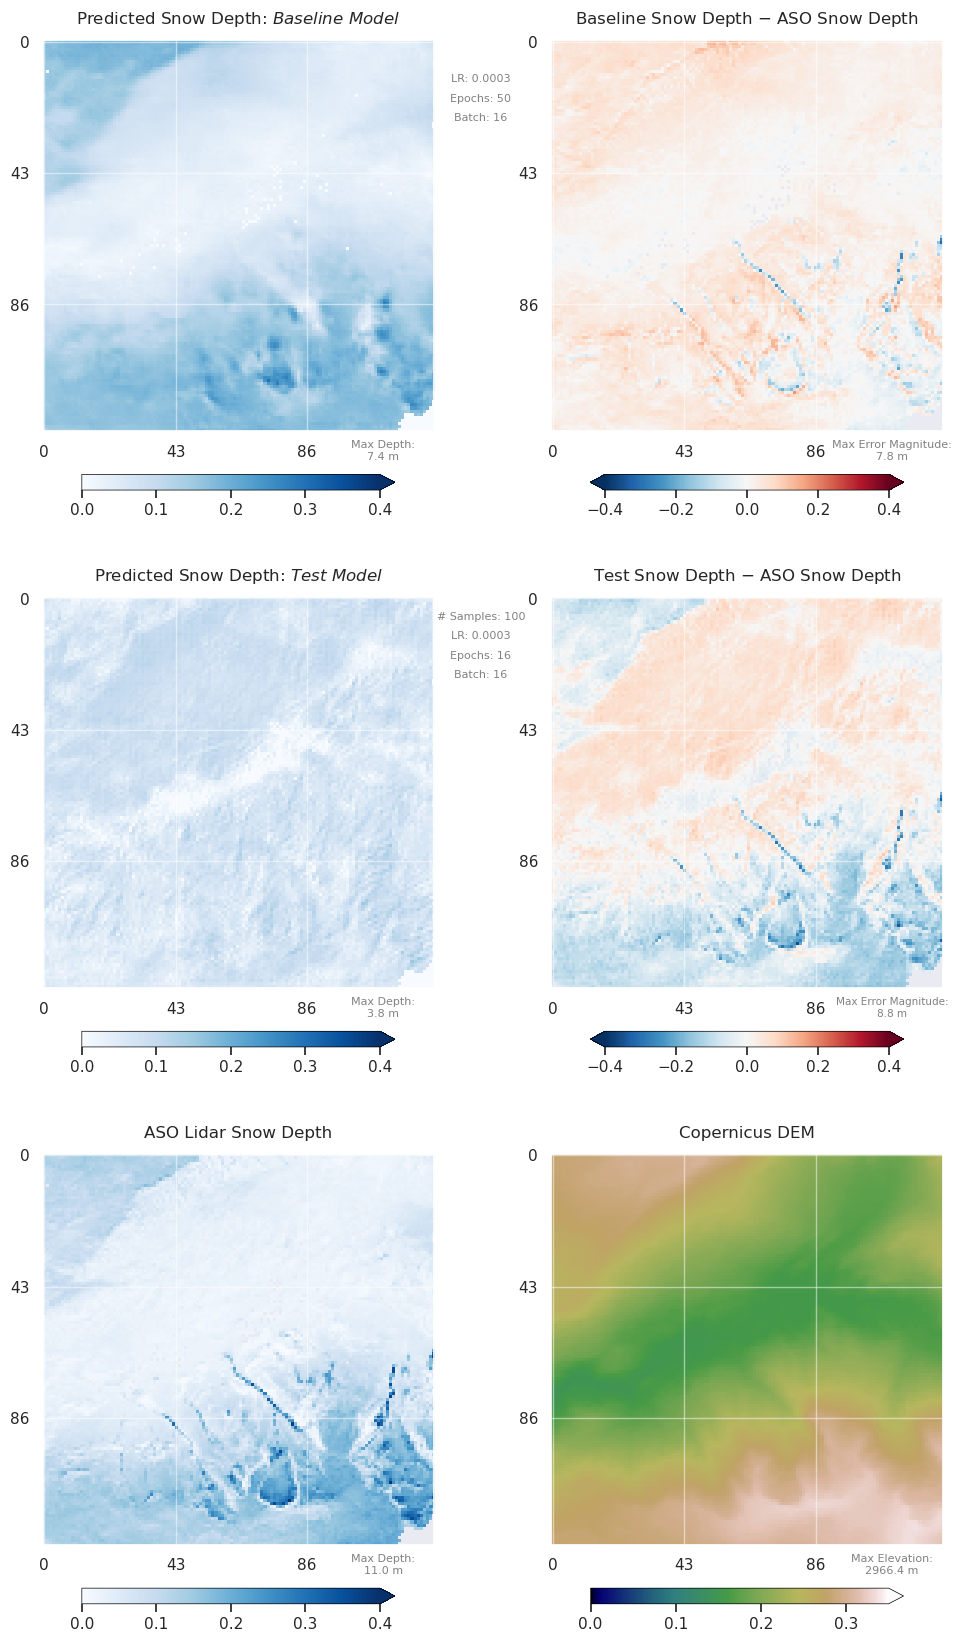

In [105]:
# visualize predictions from baseline and new model

# ----------------------------
# specify sample index to plot
#
#plot_sample = [5,13,20]
plot_sample = [16]
# ----------------------------

sns.set_theme()
norm_dict = crunchy_snow.dataset.norm_dict


for i, data_tuple in enumerate(val_loader):
    print(i)
    #if i == plot_sample:
    if i in plot_sample:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction

            if gpus == True:
                # baseline model:
                inputs_bl = torch.cat([data_dict[channel] for channel in input_channels_bl], dim=1).to('cuda')
                pred_sd_bl = model_bl(inputs_bl)  # Generate predictions using the model
                pred_sd_bl = torch.where(data_dict['aso_gap_map'].to('cpu') + data_dict['rtc_gap_map'].to('cpu') + data_dict['s2_gap_map'].to('cpu') == 0, pred_sd_bl.to('cpu'), torch.zeros_like(pred_sd_bl).to('cpu'))
                #pred_sd_bl = pred_sd_bl.to('cpu')

                # new test model:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
                pred_sd = model(inputs)  # Generate predictions using the model
                pred_sd = torch.where(data_dict['aso_gap_map'].to('cpu') + data_dict['rtc_gap_map'].to('cpu') + data_dict['s2_gap_map'].to('cpu') == 0, pred_sd.to('cpu'), torch.zeros_like(pred_sd).to('cpu'))

                #pred_sd = pred_sd.to('cpu')

                # lidar data:
                aso_sd = torch.where(data_dict['aso_gap_map'].to('cpu') + data_dict['rtc_gap_map'].to('cpu') + data_dict['s2_gap_map'].to('cpu') == 0, data_dict['aso_sd'].to('cpu'), torch.zeros_like(pred_sd).to('cpu')*np.nan)

                # elevation:
                elev = data_dict['elevation'].to('cpu')
            
            
            else:
                # baseline model:
                inputs_bl = torch.cat([data_dict[channel] for channel in input_channels_bl], dim=1)
                pred_sd_bl = model_bl(inputs_bl)  # Generate predictions using the model
                pred_sd_bl = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd_bl, torch.zeros_like(pred_sd_bl))

                # new test model:
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)
                pred_sd = model(inputs)  # Generate predictions using the model
                pred_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))

                # lidar data:
                aso_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

                # elevation:
                elev = data_dict['elevation']
        
        f, axs = plt.subplots(3, 2, figsize=(10, 18))#, sharex=True, sharey=True)
        f.patch.set_facecolor('white')

        ax = axs.flatten()

        # modify plot style
        for a in ax:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)

        # undo normalization to calculate max
        pred_sd_unnorm = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        aso_sd_unnorm = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        pred_sd_bl_unnorm = crunchy_snow.dataset.undo_norm(pred_sd_bl, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        
        elev_unnorm = crunchy_snow.dataset.undo_norm(elev, crunchy_snow.dataset.norm_dict['elevation']).squeeze()
        
        # calculate max:
        pred_sd_max = np.round(float(np.nanmax(pred_sd_unnorm)),1)
        aso_sd_max = np.round(float(np.nanmax(aso_sd_unnorm)),1)
        pred_sd_bl_max = np.round(float(np.nanmax(pred_sd_bl_unnorm)),1)
        elev_max = np.round(float(np.nanmax(elev_unnorm)),1)

        pred_bl_diff_max = np.round(float(np.nanmax(np.abs(pred_sd_bl_unnorm-aso_sd_unnorm))),1)
        pred_diff_max = np.round(float(np.nanmax(np.abs(pred_sd_unnorm-aso_sd_unnorm))),1)

        ####### Plots:
        text_sz = 8
        
        # Baseline model:
        im0 = ax[0].imshow(pred_sd_bl.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0].set_title(r'Predicted Snow Depth: $\it{Baseline\ Model}$', fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[0].text(0.87, -0.05, 'Max Depth:\n'+str(pred_sd_bl_max)+' m', fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[0].transAxes, color='gray', zorder=12) 
        ax[0].text(1.12, 0.9, 'LR: '+str(0.0003), fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[0].transAxes, color='gray', zorder=12) 
        ax[0].text(1.12, 0.85, 'Epochs: '+str(50), fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[0].transAxes, color='gray', zorder=12) 
        ax[0].text(1.12, 0.8, 'Batch: '+str(16), fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[0].transAxes, color='gray', zorder=12) 

        
        # Add axis for predicted snow depth colorbar
        cax0 = ax[0].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb0 = f.colorbar(im0, extend='max', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[0], cax=cax0)
        cb0.outline.set_visible(True)
        cb0.outline.set_linewidth(0.5)
        cb0.outline.set_edgecolor('black')

        # ----
        
        # Difference -- baseline - observations:
        im1 = ax[1].imshow((pred_sd_bl - aso_sd).squeeze(), cmap='RdBu_r', vmin=-0.4, vmax=0.4, interpolation=None) 
        ax[1].set_title(r'Baseline Snow Depth $-$ ASO Snow Depth', fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[1].text(0.87, -0.05, 'Max Error Magnitude:\n'+str(pred_bl_diff_max)+' m', fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[1].transAxes, color='gray', zorder=12) 


        # Add axis for differences colorbar
        cax1 = ax[1].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb1 = f.colorbar(im1, extend='both', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[1], cax=cax1)
        cb1.outline.set_visible(True)
        cb1.outline.set_linewidth(0.5)
        cb1.outline.set_edgecolor('black')    
        
        # ----
        
        # New model:
        im2 = ax[2].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[2].set_title(r'Predicted Snow Depth: $\it{Test\ Model}$', fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[2].text(0.87, -0.05, 'Max Depth:\n'+str(pred_sd_max)+' m', fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 
        ax[2].text(1.12, 0.95, '# Samples: '+str(n_imgs), fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 
        ax[2].text(1.12, 0.9, 'LR: '+str(learning_rate), fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 
        ax[2].text(1.12, 0.85, 'Epochs: '+str(epochs), fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 
        ax[2].text(1.12, 0.8, 'Batch: '+str(train_batch), fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[2].transAxes, color='gray', zorder=12) 

        
        # Add axis for predicted snow depth colorbar
        cax2 = ax[2].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb2 = f.colorbar(im2, extend='max', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[2], cax=cax2)
        cb2.outline.set_visible(True)
        cb2.outline.set_linewidth(0.5)
        cb2.outline.set_edgecolor('black')
        
        # ----
        
        # Difference -- new model - observations:
        im3 = ax[3].imshow((pred_sd - aso_sd).squeeze(), cmap='RdBu_r', vmin=-0.4, vmax=0.4, interpolation=None) 
        ax[3].set_title(r'Test Snow Depth $-$ ASO Snow Depth', fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[3].text(0.87, -0.05, 'Max Error Magnitude:\n'+str(pred_diff_max)+' m', fontsize=7.5, fontweight='medium', ha='center', va='center', transform=ax[3].transAxes, color='gray', zorder=12) 

        
        # Add axis for differences colorbar
        cax3 = ax[3].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb3 = f.colorbar(im3, extend='both', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[3], cax=cax3)
        cb3.outline.set_visible(True)
        cb3.outline.set_linewidth(0.5)
        cb3.outline.set_edgecolor('black')   
        
        # ----
        
        # Lidar snow depth:
        im4 = ax[4].imshow(aso_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[4].set_title('ASO Lidar Snow Depth',fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[4].text(0.87, -0.05, 'Max Depth:\n'+str(aso_sd_max)+' m', fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[4].transAxes, color='gray', zorder=12) 


        # Add axis for observed snow depth colorbar
        cax4 = ax[4].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb4 = f.colorbar(im4, extend='max', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[4], cax=cax4)
        cb4.outline.set_visible(True)
        cb4.outline.set_linewidth(0.5)
        cb4.outline.set_edgecolor('black')

        # ----
        
        # Elevation:
        im5 = ax[5].imshow(data_dict['elevation'].squeeze(), cmap='gist_earth', vmin=0, vmax=0.35, interpolation=None)
        ax[5].set_title('Copernicus DEM',fontsize=12,y=1.02,loc='center', horizontalalignment='center')
        ax[5].text(0.87, -0.05, 'Max Elevation:\n'+str(elev_max)+' m', fontsize=text_sz, fontweight='medium', ha='center', va='center', transform=ax[5].transAxes, color='gray', zorder=12) 


        # Add axis for elevation colorbar
        cax5 = ax[5].inset_axes([0.1, -0.15, 0.8, 0.04])
        cb5 = f.colorbar(im5, extend='max', orientation="horizontal",pad=0.1,fraction=0.037,shrink=0.9,aspect=35,ax=ax[5], cax=cax5)
        cb5.outline.set_visible(True)
        cb5.outline.set_linewidth(0.5)
        cb5.outline.set_edgecolor('black')
        
        # Clean up subplots / layout.
        f.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.95, wspace=0.3, hspace=0.1)

        plt.savefig(f'/home/jovyan/crunchy-snow/figs/snowdepth_{model_baseline}_{model_name}_sample{plot_sample}_{n_imgs}imgs_{epochs}epochs.png', dpi=300)

        del(f)

    elif i < plot_sample[-1]:
        continue

    else:
        break

In [97]:
# Plot RMSE and max error for each sample

nsample = []
rmse_pred_sd = []
max_err_pred_sd = []

rmse_pred_sd_bl = []
max_err_pred_sd_bl = []

for i, data_tuple in enumerate(val_loader):
    nsample.append(i)
    print(i)

    # read data into dictionary
    data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

    with torch.no_grad():
        # Concatenate input feature channels, make prediction

        if gpus == True:
            
            # baseline model:
            inputs_bl = torch.cat([data_dict[channel] for channel in input_channels_bl], dim=1).to('cuda')
            pred_sd_bl = model_bl(inputs_bl)  # Generate predictions using the model
            pred_sd_bl = pred_sd_bl.to('cpu')
            #torch.where(data_dict['aso_gap_map'].to('cpu') + data_dict['rtc_gap_map'].to('cpu') + data_dict['s2_gap_map'].to('cpu') == 0, pred_sd_bl.to('cpu'), torch.zeros_like(pred_sd_bl).to('cpu')*np.nan)

            # new test model:
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            #pred_sd = torch.where(data_dict['aso_gap_map'].to('cpu') + data_dict['rtc_gap_map'].to('cpu') + data_dict['s2_gap_map'].to('cpu') == 0, pred_sd.to('cpu'), torch.zeros_like(pred_sd).to('cpu')*np.nan)
            pred_sd = pred_sd.to('cpu')
            
            # lidar data:
            aso_sd = data_dict['aso_sd'].to('cpu')

            # mask
            mask_sd = data_dict['aso_gap_map'].to('cpu') + data_dict['rtc_gap_map'].to('cpu') + data_dict['s2_gap_map'].to('cpu')
   
        else:
            # baseline model:
            inputs_bl = torch.cat([data_dict[channel] for channel in input_channels_bl], dim=1)
            pred_sd_bl = model_bl(inputs_bl)  # Generate predictions using the model

            # new test model:
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)
            pred_sd = model(inputs)  # Generate predictions using the model

             # lidar data:
            aso_sd = data_dict['aso_sd'] 

            # mask
            mask_sd = data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map']
   

        # undo normalization to calculate max
        pred_sd_unnorm = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        aso_sd_unnorm = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
        pred_sd_bl_unnorm = crunchy_snow.dataset.undo_norm(pred_sd_bl, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()

        # Apply masking here
        pred_sd_unnorm_mask = torch.where(mask_sd == 0, pred_sd_unnorm, torch.zeros_like(pred_sd_unnorm)*np.nan)
        pred_sd_bl_unnorm_mask = torch.where(mask_sd == 0, pred_sd_bl_unnorm, torch.zeros_like(pred_sd_bl_unnorm)*np.nan)
        aso_sd_unnorm_mask = torch.where(mask_sd == 0, aso_sd_unnorm, torch.zeros_like(aso_sd_unnorm)*np.nan)

        # print(pred_sd_unnorm_mask.shape)
        # print(pred_sd_unnorm_mask)
        # print(pred_sd_unnorm.shape)

        # Drop nans
        pred_sd_unnorm_nonan = pred_sd_unnorm_mask.flatten()[~pred_sd_unnorm_mask.flatten().isnan()]
        pred_sd_bl_unnorm_nonan = pred_sd_bl_unnorm_mask.flatten()[~pred_sd_bl_unnorm_mask.flatten().isnan()]
        aso_sd_unnorm_nonan = aso_sd_unnorm_mask.flatten()[~aso_sd_unnorm_mask.flatten().isnan()]

        #print(pred_sd_unnorm_nonan.shape)

        try:
            pred_sd_rmse = skmetrics.mean_squared_error(aso_sd_unnorm_nonan, pred_sd_unnorm_nonan, squared=False)   
            rmse_pred_sd.append(pred_sd_rmse)
        
            pred_sd_maxerr = skmetrics.max_error(aso_sd_unnorm_nonan, pred_sd_unnorm_nonan)
            max_err_pred_sd.append(pred_sd_maxerr)
            
            pred_sd_bl_rmse = skmetrics.mean_squared_error(aso_sd_unnorm_nonan, pred_sd_bl_unnorm_nonan, squared=False)   
            rmse_pred_sd_bl.append(pred_sd_bl_rmse)
            
            pred_sd_bl_maxerr = skmetrics.max_error(aso_sd_unnorm_nonan, pred_sd_bl_unnorm_nonan)
            max_err_pred_sd_bl.append(pred_sd_bl_maxerr)
            
        except:
            rmse_pred_sd.append(np.nan)
            rmse_pred_sd_bl.append(np.nan)
            max_err_pred_sd.append(np.nan)
            max_err_pred_sd_bl.append(np.nan)


        
        # pred_sd_rmse = skmetrics.mean_squared_error(aso_sd_unnorm, pred_sd_unnorm, squared=False)   
        # rmse_pred_sd.append(pred_sd_rmse)

        # pred_sd_maxerr = skmetrics.max_error(aso_sd_unnorm.flatten(), pred_sd_unnorm.flatten())
        # max_err_pred_sd.append(pred_sd_maxerr)

        # pred_sd_bl_rmse = skmetrics.mean_squared_error(aso_sd_unnorm, pred_sd_bl_unnorm, squared=False)   
        # rmse_pred_sd_bl.append(pred_sd_bl_rmse)

        # pred_sd_bl_maxerr = skmetrics.max_error(aso_sd_unnorm.flatten(), pred_sd_bl_unnorm.flatten())
        # max_err_pred_sd_bl.append(pred_sd_bl_maxerr)


0
torch.Size([1, 1, 128, 128])
tensor([[[[ 1.3980,  1.8268,  1.7822,  ...,  2.1223,  1.8021,  1.2934],
          [ 2.4712,  2.5438,  1.7671,  ...,  2.1156,  1.6891,  0.7813],
          [ 1.9010,  2.3292,  2.0512,  ...,  2.3383,  1.6519,  0.8307],
          ...,
          [ 1.2236,  1.0195,  1.3027,  ...,  0.9213,  0.0428,  0.7507],
          [ 0.1631,  1.3032,  1.4040,  ...,  0.6503, -0.0095,     nan],
          [ 1.1500,  1.8801,  1.6327,  ...,     nan,  0.5989,  0.8934]]]])
torch.Size([128, 128])
torch.Size([16073])
1
torch.Size([1, 1, 128, 128])
tensor([[[[ 0.0694,  0.4195,  0.2743,  ...,  0.2055, -0.0097,  0.4212],
          [ 0.3299,  0.1866,  0.1030,  ..., -0.0181,  0.2774,  0.5317],
          [ 0.1089, -0.0425, -0.0654,  ..., -0.1159,  0.1158,  0.4649],
          ...,
          [    nan,     nan,     nan,  ...,  0.2652, -0.0058,  0.1499],
          [    nan,     nan,     nan,  ...,  0.3487,  0.2755,  0.4589],
          [    nan,     nan,     nan,  ...,  0.4848,  0.3701,  0.1636]

In [ ]:
pred_sd_unnorm_nonan = pred_sd_unnorm.flatten()[~pred_sd_unnorm.flatten().isnan()]
pred_sd_bl_unnorm_nonan = pred_sd_bl_unnorm.flatten()[~pred_sd_bl_unnorm.flatten().isnan()]
aso_sd_unnorm_nonan = aso_sd_unnorm.flatten()[~aso_sd_unnorm.flatten().isnan()]


pred_sd_rmse = skmetrics.mean_squared_error(aso_sd_unnorm_nonan, pred_sd_unnorm_nonan, squared=False)   
rmse_pred_sd.append(pred_sd_rmse)

pred_sd_maxerr = skmetrics.max_error(aso_sd_unnorm_nonan, pred_sd_unnorm_nonan)
max_err_pred_sd.append(pred_sd_maxerr)

pred_sd_bl_rmse = skmetrics.mean_squared_error(aso_sd_unnorm_nonan, pred_sd_bl_unnorm_nonan, squared=False)   
rmse_pred_sd_bl.append(pred_sd_bl_rmse)

pred_sd_bl_maxerr = skmetrics.max_error(aso_sd_unnorm_nonan, pred_sd_bl_unnorm_nonan)
max_err_pred_sd_bl.append(pred_sd_bl_maxerr)


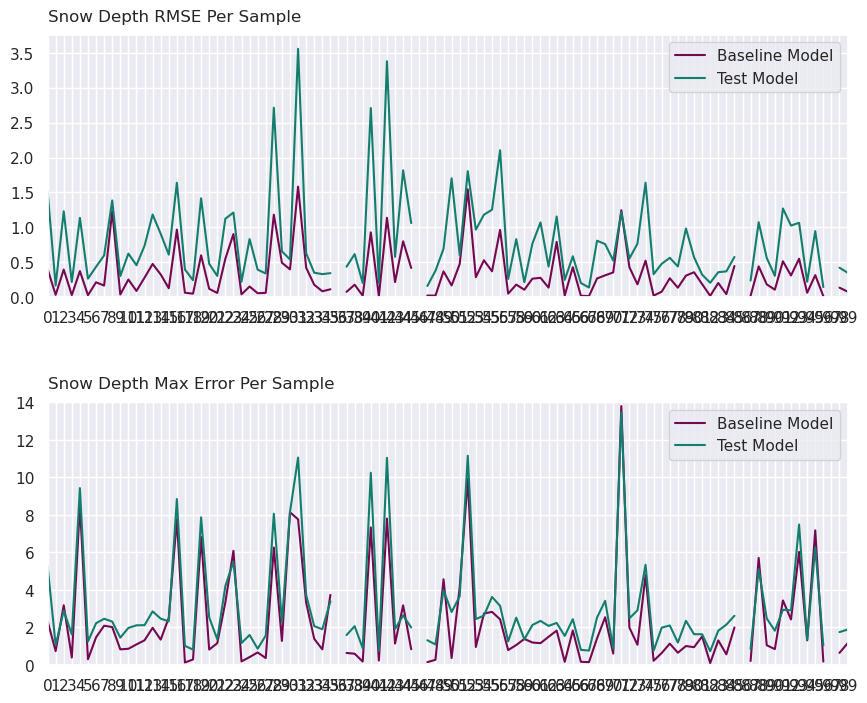

In [98]:
# plot error for each sample

sns.set_theme()

f, axs = plt.subplots(2,1,figsize=(10,7))

ax = axs.flatten()

# RMSE for models
ax[0].plot(rmse_pred_sd_bl, color='xkcd:velvet', label='Baseline Model')
ax[0].plot(rmse_pred_sd, color='xkcd:blue green', label='Test Model')

ax[0].set_xlim([0,len(rmse_pred_sd)-1])
ax[0].set_xticks(np.arange(0,len(rmse_pred_sd_bl),1))
ax[0].set_ylim([0,max(np.maximum(rmse_pred_sd_bl,rmse_pred_sd))+0.2])

ax[0].set_title(r'Snow Depth RMSE Per Sample', fontsize=12,y=1.02,loc='left', horizontalalignment='left')
ax[0].legend()

# Max errors for models
ax[1].plot(max_err_pred_sd_bl, color='xkcd:velvet', label='Baseline Model')
ax[1].plot(max_err_pred_sd, color='xkcd:blue green', label='Test Model')

ax[1].set_xlim([0,len(max_err_pred_sd_bl)-1])
ax[1].set_xticks(np.arange(0,len(max_err_pred_sd_bl),1))
ax[1].set_ylim([int(min(np.minimum(max_err_pred_sd_bl,max_err_pred_sd))-0.2),max(np.maximum(max_err_pred_sd_bl,max_err_pred_sd))+0.2])

ax[1].set_title(r'Snow Depth Max Error Per Sample', fontsize=12,y=1.02,loc='left', horizontalalignment='left')
ax[1].legend()

# Clean up subplots / layout.
f.subplots_adjust(bottom=0.05, top=0.95, left=0.1, right=0.9, wspace=0.45, hspace=0.4)


# save figure
#plt.savefig(f'/home/jovyan/crunchy-snow/figs/errorpersample_{model_baseline}_{model_name}_{n_imgs}imgs_{epochs}eps.png', dpi=300)


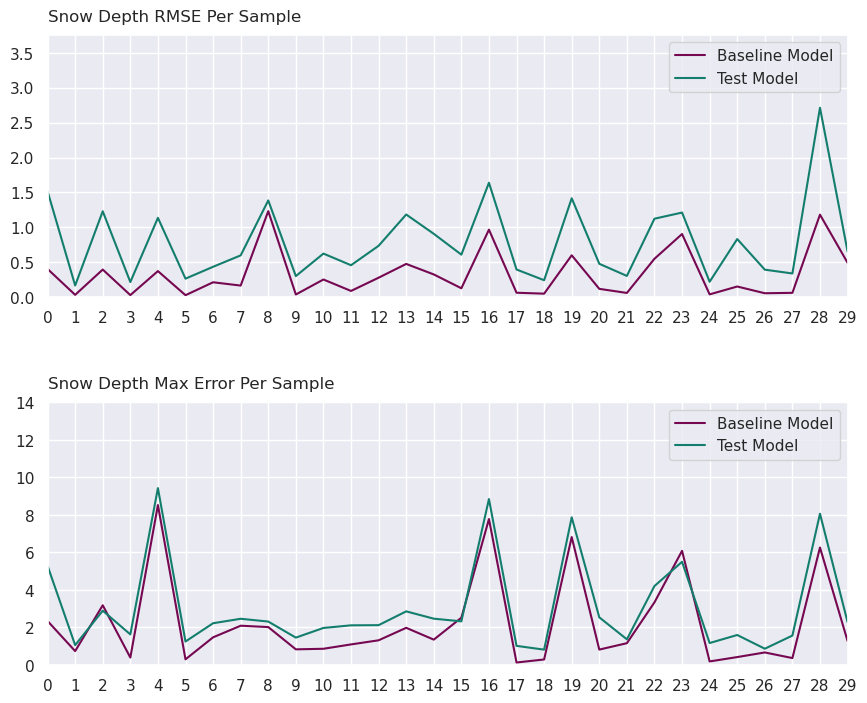

In [102]:
# plot error for each sample

sns.set_theme()

f, axs = plt.subplots(2,1,figsize=(10,7))

ax = axs.flatten()

# RMSE for models
ax[0].plot(rmse_pred_sd_bl, color='xkcd:velvet', label='Baseline Model')
ax[0].plot(rmse_pred_sd, color='xkcd:blue green', label='Test Model')

subset_len = 30

ax[0].set_xlim([0,subset_len-1])
ax[0].set_xticks(np.arange(0,subset_len,1))
ax[0].set_ylim([0,max(np.maximum(rmse_pred_sd_bl,rmse_pred_sd))+0.2])

ax[0].set_title(r'Snow Depth RMSE Per Sample', fontsize=12,y=1.02,loc='left', horizontalalignment='left')
ax[0].legend()

# Max errors for models
ax[1].plot(max_err_pred_sd_bl, color='xkcd:velvet', label='Baseline Model')
ax[1].plot(max_err_pred_sd, color='xkcd:blue green', label='Test Model')

ax[1].set_xlim([0,subset_len-1])
ax[1].set_xticks(np.arange(0,subset_len,1))
ax[1].set_ylim([int(min(np.minimum(max_err_pred_sd_bl,max_err_pred_sd))-0.2),max(np.maximum(max_err_pred_sd_bl,max_err_pred_sd))+0.2])

ax[1].set_title(r'Snow Depth Max Error Per Sample', fontsize=12,y=1.02,loc='left', horizontalalignment='left')
ax[1].legend()

# Clean up subplots / layout.
f.subplots_adjust(bottom=0.05, top=0.95, left=0.1, right=0.9, wspace=0.45, hspace=0.4)


# save figure
plt.savefig(f'/home/jovyan/crunchy-snow/figs/errorpersample_{model_baseline}_{model_name}_{n_imgs}imgs_{epochs}eps_subset.png', dpi=300)
